In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from Functions.AlphaBeta import AlphaBeta, expanded_risk_metrics, downside_metrics

In [70]:
def Get_crypto_data():
    # Download both BTC-USD and ETH-USD data
    btc = yf.download('BTC-USD', start='2023-01-01')[['Adj Close']].rename(columns={'Adj Close': 'BTC_USD'})
    eth = yf.download('ETH-USD', start='2023-01-01')[['Adj Close']].rename(columns={'Adj Close': 'ETH_USD'})
    
    # Combine the data
    data = pd.concat([btc, eth], axis=1)
    
    # Calculate BTC-ETH ratio
    data['BTC_ETH'] = data['BTC_USD'] / data['ETH_USD']
    
    # Calculate rolling statistics
    data['Spread_Mean'] = data['BTC_ETH'].rolling(window=30).mean()
    data['Spread_Std'] = data['BTC_ETH'].rolling(window=30).std()
    data['Upper_Band'] = data['Spread_Mean'] + 1*data['Spread_Std']
    data['Lower_Band'] = data['Spread_Mean'] - 1*data['Spread_Std']
    
    data.dropna(inplace=True)
    return data
data = Get_crypto_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [72]:
def pair_trading_backtest_mtm(data, initial_balance_usd=10000):
    balance_usd = initial_balance_usd
    btc_holdings = 0
    eth_holdings = 0
    in_btc = False
    trade_log = []
    daily_value = []

    for i in range(len(data)):
        date = data.index[i]
        ratio = data['BTC_ETH'].iloc[i]
        upper_band = data['Upper_Band'].iloc[i]
        lower_band = data['Lower_Band'].iloc[i]
        btc_price = data['BTC_USD'].iloc[i]
        eth_price = data['ETH_USD'].iloc[i]

        # Calculate portfolio value for this day
        if i == 0:  # First day
            eth_holdings = initial_balance_usd / eth_price
            daily_value.append({
                'Date': date,
                'Portfolio_USD': initial_balance_usd,
                'BTC_Holdings': btc_holdings,
                'ETH_Holdings': eth_holdings
            })
        
        if ratio < lower_band and not in_btc:
            if eth_holdings == 0:  # First trade
                eth_holdings = balance_usd / eth_price
                balance_usd = 0
            
            btc_holdings = (eth_holdings * eth_price) / btc_price
            eth_holdings = 0
            in_btc = True
            
            trade_log.append({
                'Date': date,
                'Action': 'BUY_BTC',
                'Ratio': ratio,
                'BTC_Holdings': btc_holdings,
                'ETH_Holdings': eth_holdings,
                'Portfolio_USD': btc_holdings * btc_price
            })
            
        elif ratio > upper_band and in_btc:
            eth_holdings = (btc_holdings * btc_price) / eth_price
            btc_holdings = 0
            in_btc = False
            
            trade_log.append({
                'Date': date,
                'Action': 'SELL_BTC',
                'Ratio': ratio,
                'BTC_Holdings': btc_holdings,
                'ETH_Holdings': eth_holdings,
                'Portfolio_USD': eth_holdings * eth_price
            })

        # Calculate daily portfolio value
        current_value = btc_holdings * btc_price + eth_holdings * eth_price
        daily_value.append({
            'Date': date,
            'Portfolio_USD': current_value,
            'BTC_Holdings': btc_holdings,
            'ETH_Holdings': eth_holdings
        })

    trade_log = pd.DataFrame(trade_log)
    trade_log.set_index('Date', inplace=True)
    
    daily_value = pd.DataFrame(daily_value)
    daily_value.set_index('Date', inplace=True)
    
    return daily_value, trade_log

In [74]:
daily_value, trade_log = pair_trading_backtest_mtm(data)

In [76]:
def plot_trading(data, daily_value, trade_log):
    # First plot remains the same
    plt.figure(figsize=(14, 8))
    data['BTC_ETH'].plot(label='BTC/ETH ratio')
    data['Spread_Mean'].plot(label='Spread Mean', style='--')
    data['Upper_Band'].plot(label='Upper Band', style='--')
    data['Lower_Band'].plot(label='Lower Band', style='--')

    if not trade_log.empty:
        buy_points = trade_log[trade_log['Action'] == 'BUY_BTC']
        sell_points = trade_log[trade_log['Action'] == 'SELL_BTC']

        plt.scatter(buy_points.index, 
                   data.loc[buy_points.index, 'BTC_ETH'],
                   label='Buy Signal', 
                   color='green', 
                   zorder=5)
        plt.scatter(sell_points.index, 
                   data.loc[sell_points.index, 'BTC_ETH'],
                   label='Sell Signal', 
                   color='red', 
                   zorder=5)

    plt.title('BTC/ETH Pair Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('BTC/ETH ratio')
    plt.legend()
    plt.show()

    # Second plot: Portfolio Value
    plt.figure(figsize=(14, 8))
    daily_value['Portfolio_USD'].plot(color='blue', label='Portfolio Value')
    
    # Add markers for buy and sell points on portfolio value
    if not trade_log.empty:
        buy_points = trade_log[trade_log['Action'] == 'BUY_BTC']
        sell_points = trade_log[trade_log['Action'] == 'SELL_BTC']
        
        plt.scatter(buy_points.index, 
                   daily_value.loc[buy_points.index, 'Portfolio_USD'],
                   color='green',
                   label='Buy Point',
                   zorder=5)
        plt.scatter(sell_points.index, 
                   daily_value.loc[sell_points.index, 'Portfolio_USD'],
                   color='red',
                   label='Sell Point',
                   zorder=5)

    plt.axhline(y=10000, color='gray', linestyle='--', label='Initial Investment')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.show()

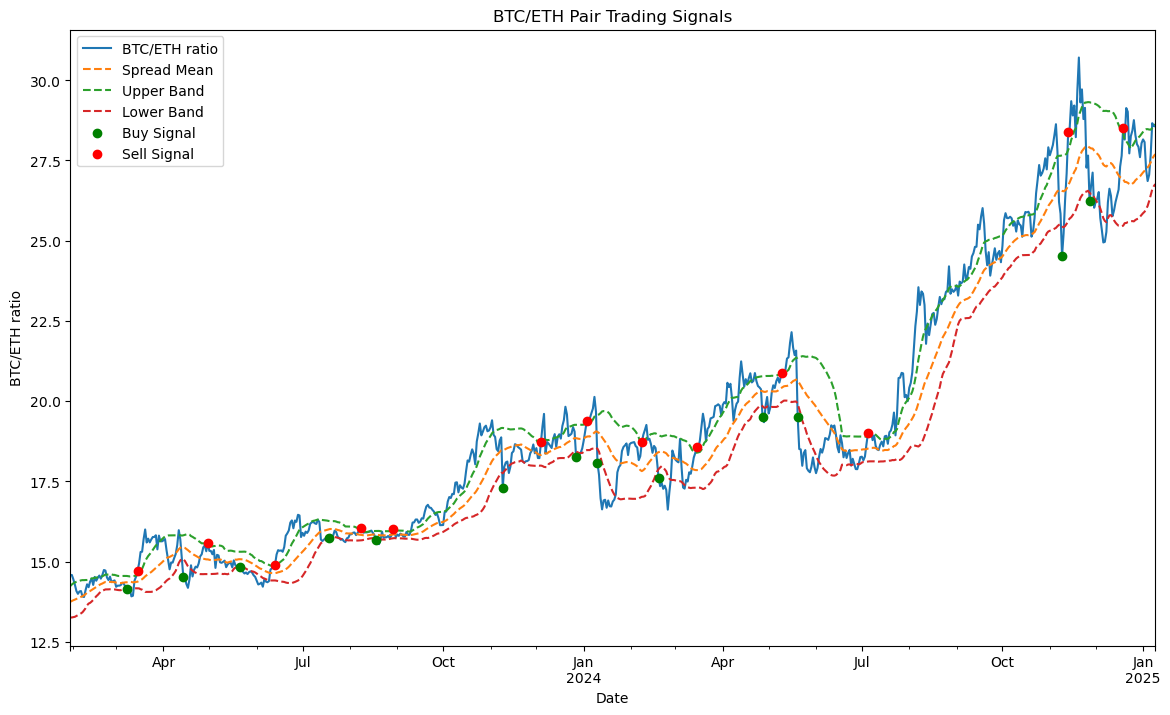

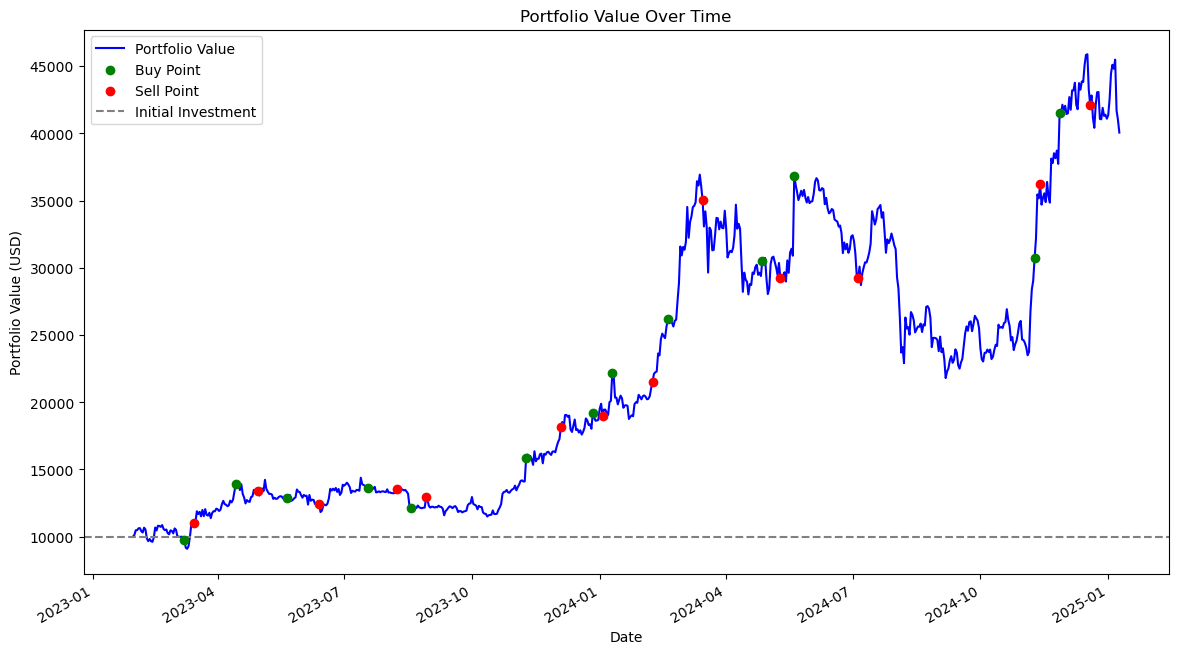

In [78]:
plot_trading(data, daily_value, trade_log)

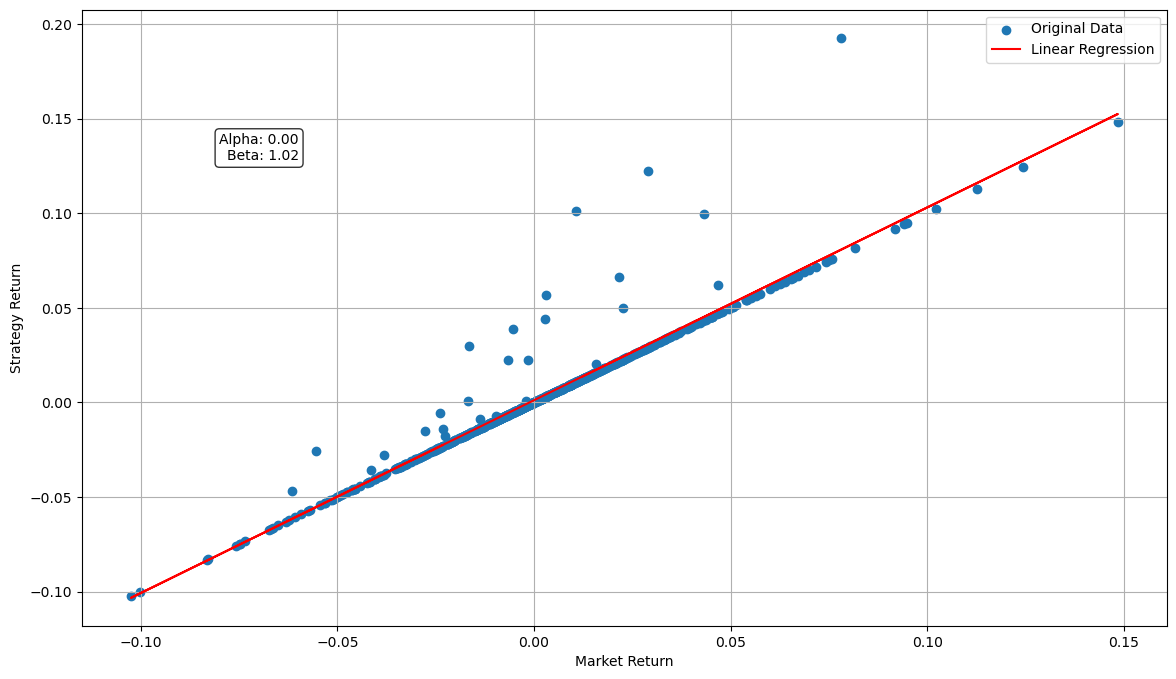


Performance Evaluation:
Alpha: 0.0010
meh: Slight outperformance: Strategy generates minimal excess returns
Beta: 1.0190
meh: Market-like risk: Strategy closely tracks market movements

Risk Metrics:
Sharpe Ratio: 0.0801
IS TIME TO STOP: Poor risk-adjusted returns (Sharpe < 0.5)

Downside Metrics:
Maximum Drawdown: -0.4097
IS TIME TO STOP: Severe maximum drawdown (> 30%)


In [90]:
def calculate_returns(daily_value, data, trade_log):
    # Calculate strategy returns
    portfolio_values = daily_value['Portfolio_USD']
    strategy_returns = portfolio_values.pct_change().dropna()
    
    # Create market returns based on holdings
    market_returns = []
    dates = []
    current_holding = 'ETH'  # Start with ETH as per your strategy
    
    for i in range(1, len(data)):  # Start from 1 to calculate returns
        date = data.index[i]
        
        # Check if there's a trade on this date
        if date in trade_log.index:
            action = trade_log.loc[date, 'Action']
            if action == 'BUY_BTC':
                current_holding = 'BTC'
            elif action == 'SELL_BTC':
                current_holding = 'ETH'
        
        # Calculate return based on current holding
        if current_holding == 'BTC':
            daily_return = data['BTC_USD'].iloc[i] / data['BTC_USD'].iloc[i-1] - 1
        else:  # ETH
            daily_return = data['ETH_USD'].iloc[i] / data['ETH_USD'].iloc[i-1] - 1
            
        market_returns.append(daily_return)
        dates.append(date)
    
    market_returns = pd.Series(market_returns, index=dates)
    
    # Align the dates
    common_dates = strategy_returns.index.intersection(market_returns.index)
    strategy_returns = strategy_returns[common_dates]
    market_returns = market_returns[common_dates]
    
    return strategy_returns, market_returns

def analyze_strategy(daily_value, data, trade_log):
    # Get returns
    strategy_returns, market_returns = calculate_returns(daily_value, data, trade_log)
    
    # Calculate Alpha and Beta with plot
    alpha, beta = AlphaBeta(strategy_returns, market_returns, plot=True, fsize=(14, 8))
    
    # Calculate additional risk metrics
    risk_metrics = expanded_risk_metrics(strategy_returns, market_returns)
    downside_stats = downside_metrics(strategy_returns, market_returns)

    # Performance Evaluation
    print("\nPerformance Evaluation:")
    
    print(f"Alpha: {alpha:.4f}")
    if alpha > 0.01:
        print("nice job team: Strong outperformance: Strategy generates significant excess returns")
    elif alpha > 0:
        print("meh: Slight outperformance: Strategy generates minimal excess returns")
    else:
        print("IS TIME TO STOP: Underperformance: Strategy fails to generate excess returns")
    
    print(f"Beta: {beta:.4f}")
    if 0.8 <= beta <= 1.2:
        print("meh: Market-like risk: Strategy closely tracks market movements")
    elif beta < 0.8:
        print("nice job team: Lower market risk: Strategy shows good risk control")
    else:
        print("IS TIME TO STOP: High market risk: Strategy amplifies market movements")
    
    print(f"\nRisk Metrics:")
    print(f"Sharpe Ratio: {risk_metrics['sharpe']:.4f}")
    if risk_metrics['sharpe'] > 1:
        print("nice job team: Good risk-adjusted returns (Sharpe > 1)")
    elif risk_metrics['sharpe'] > 0.5:
        print("meh: Moderate risk-adjusted returns (0.5 < Sharpe < 1)")
    else:
        print("IS TIME TO STOP: Poor risk-adjusted returns (Sharpe < 0.5)")
    
    print(f"\nDownside Metrics:")
    print(f"Maximum Drawdown: {downside_stats['max_drawdown']:.4f}")
    if downside_stats['max_drawdown'] > -0.2:
        print("nice job team: Acceptable maximum drawdown (< 20%)")
    elif downside_stats['max_drawdown'] > -0.3:
        print("meh: High maximum drawdown (20-30%)")
    else:
        print("IS TIME TO STOP: Severe maximum drawdown (> 30%)")
    
    return alpha, beta, risk_metrics, downside_stats

# Run the analysis
daily_value, trade_log = pair_trading_backtest_mtm(data)
alpha, beta, risk_metrics, downside_stats = analyze_strategy(daily_value, data, trade_log)